In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/GM.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,29.410000,29.500000,28.629999,29.129999,22.284592,15605900
1,1/3/2013,29.049999,30.230000,28.840000,29.820000,22.812448,22903800
2,1/4/2013,29.740000,29.860001,29.230000,29.860001,22.843050,8066600
3,1/7/2013,29.639999,29.860001,29.299999,29.660000,22.690046,8385300
4,1/8/2013,29.660000,29.850000,29.049999,29.370001,22.468195,10435200


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -50.519960.3, cost: 0.005294, total money: 9441.990038
epoch: 20, total rewards: 21.769996.3, cost: 0.008457, total money: 9691.149998
epoch: 30, total rewards: 169.779959.3, cost: 0.009375, total money: 9771.489954
epoch: 40, total rewards: -45.109966.3, cost: 0.001872, total money: 9881.540031
epoch: 50, total rewards: 10.050024.3, cost: 0.001463, total money: 10010.050024
epoch: 60, total rewards: -18.119965.3, cost: 0.012139, total money: 9945.440037
epoch: 70, total rewards: 39.799982.3, cost: 0.000996, total money: 10003.319983
epoch: 80, total rewards: 17.110012.3, cost: 0.000979, total money: 9906.910008
epoch: 90, total rewards: -38.510010.3, cost: 0.000225, total money: 9925.009991
epoch: 100, total rewards: 56.370016.3, cost: 0.000125, total money: 10056.370016
epoch: 110, to

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 29.490000, total balance 9970.510000
day 13, sell 1 unit at price 28.629999, investment -2.916245 %, total balance 9999.139999,
day 19: buy 1 unit at price 27.940001, total balance 9971.199999
day 21, sell 1 unit at price 28.170000, investment 0.823191 %, total balance 9999.369999,
day 27: buy 1 unit at price 28.530001, total balance 9970.839998
day 29, sell 1 unit at price 28.670000, investment 0.490709 %, total balance 9999.509998,
day 31: buy 1 unit at price 27.760000, total balance 9971.749998
day 33, sell 1 unit at price 27.100000, investment -2.377521 %, total balance 9998.849998,
day 49: buy 1 unit at price 28.160000, total balance 9970.689999
day 50, sell 1 unit at price 28.209999, investment 0.177554 %, total balance 9998.899998,
day 56: buy 1 unit at price 28.160000, total balance 9970.739998
day 58, sell 1 unit at price 28.059999, investment -0.355115 %, total balance 9998.799997,
day 62: buy 1 unit at price 27.799999, total balance 9970.999998
da

day 410, sell 1 unit at price 34.570000, investment 0.494181 %, total balance 9995.789997,
day 430: buy 1 unit at price 33.849998, total balance 9961.939999
day 431, sell 1 unit at price 34.029999, investment 0.531759 %, total balance 9995.969997,
day 443: buy 1 unit at price 33.750000, total balance 9962.219997
day 444, sell 1 unit at price 31.770000, investment -5.866665 %, total balance 9993.989998,
day 445: buy 1 unit at price 32.180000, total balance 9961.809998
day 446, sell 1 unit at price 31.030001, investment -3.573647 %, total balance 9992.839998,
day 447: buy 1 unit at price 30.290001, total balance 9962.549997
day 448, sell 1 unit at price 29.790001, investment -1.650710 %, total balance 9992.339998,
day 477: buy 1 unit at price 32.130001, total balance 9960.209997
day 478, sell 1 unit at price 32.189999, investment 0.186734 %, total balance 9992.399996,
day 480: buy 1 unit at price 32.070000, total balance 9960.329996
day 481, sell 1 unit at price 33.430000, investment 4.2

day 756: buy 1 unit at price 33.310001, total balance 9971.929989
day 757, sell 1 unit at price 32.430000, investment -2.641852 %, total balance 10004.359989,
day 781: buy 1 unit at price 27.870001, total balance 9976.489988
day 782: buy 1 unit at price 27.709999, total balance 9948.779989
day 783, sell 1 unit at price 26.900000, investment -3.480449 %, total balance 9975.679989,
day 784, sell 1 unit at price 27.709999, investment 0.000000 %, total balance 10003.389988,
day 791: buy 1 unit at price 28.840000, total balance 9974.549988
day 793: buy 1 unit at price 29.629999, total balance 9944.919989
day 794, sell 1 unit at price 29.440001, investment 2.080445 %, total balance 9974.359989,
day 795, sell 1 unit at price 30.010000, investment 1.282488 %, total balance 10004.369989,
day 797: buy 1 unit at price 31.070000, total balance 9973.299990
day 799, sell 1 unit at price 31.590000, investment 1.673642 %, total balance 10004.889990,
day 814: buy 1 unit at price 31.190001, total balanc

day 1202: buy 1 unit at price 45.209999, total balance 9963.950012
day 1203, sell 1 unit at price 45.470001, investment 0.575099 %, total balance 10009.420013,
day 1206: buy 1 unit at price 45.759998, total balance 9963.660015
day 1207, sell 1 unit at price 45.020000, investment -1.617128 %, total balance 10008.680016,
day 1213: buy 1 unit at price 45.119999, total balance 9963.560017
day 1214: buy 1 unit at price 45.250000, total balance 9918.310017
day 1215, sell 1 unit at price 44.639999, investment -1.063829 %, total balance 9962.950016,
day 1216, sell 1 unit at price 43.369999, investment -4.154698 %, total balance 10006.320015,
day 1227: buy 1 unit at price 43.000000, total balance 9963.320015
day 1228, sell 1 unit at price 42.860001, investment -0.325580 %, total balance 10006.180016,
day 1232: buy 1 unit at price 44.970001, total balance 9961.210014
day 1233, sell 1 unit at price 44.290001, investment -1.512120 %, total balance 10005.500015,
day 1237: buy 1 unit at price 43.810

day 1567: buy 1 unit at price 36.869999, total balance 9959.190016
day 1569, sell 1 unit at price 37.060001, investment 0.515331 %, total balance 9996.250017,
day 1573: buy 1 unit at price 38.389999, total balance 9957.860018
day 1574, sell 1 unit at price 38.790001, investment 1.041942 %, total balance 9996.650019,
day 1575: buy 1 unit at price 38.939999, total balance 9957.710020
day 1576, sell 1 unit at price 39.060001, investment 0.308173 %, total balance 9996.770021,
day 1580: buy 1 unit at price 39.709999, total balance 9957.060022
day 1581: buy 1 unit at price 39.570000, total balance 9917.490023
day 1583, sell 1 unit at price 39.990002, investment 0.705119 %, total balance 9957.480024,
day 1584, sell 1 unit at price 40.299999, investment 1.844831 %, total balance 9997.780024,
day 1585: buy 1 unit at price 39.500000, total balance 9958.280024
day 1586, sell 1 unit at price 39.830002, investment 0.835448 %, total balance 9998.110025,
day 1589: buy 1 unit at price 39.680000, total

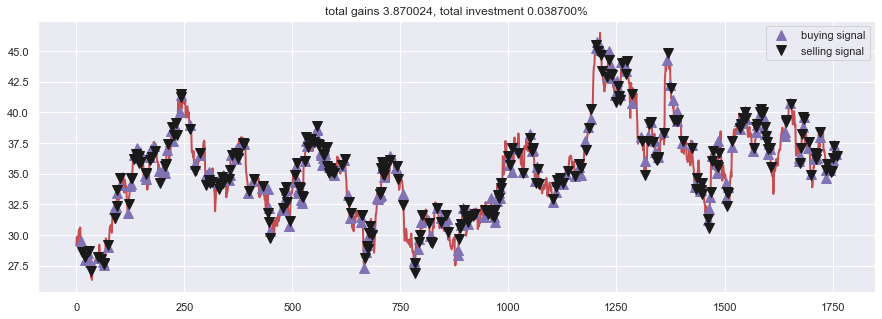

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()